# Generate cellxgene

In [15]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import os
import sys

sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = './figures/'
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

'/home/jovyan/my-conda-envs/sc_analysis/bin/python'

# Prepare INPUT

## Load raw and annoted andata

In [16]:
path_to_gonads = '/nfs/team292/lg18/with_valentina/gonadsV2_revision/'

In [17]:
adata = sc.read(path_to_gonads + 'mouse-gonads_rawcounts.h5ad')
adata = adata[[ 'female' not in i for i in adata.obs.sex]]
adata.X.shape

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(33017, 24482)

In [18]:
adata_annotated = sc.read(path_to_gonads+'/mouse-gonads_male.h5ad')
adata_annotated.X.shape

(33017, 23713)

### Import lineage and somatic annotation

In [19]:
cell_annot = adata_annotated.obs['lineage'].to_dict()
adata.obs['lineage'] = adata.obs_names.map(cell_annot)
adata.obs['lineage'].value_counts()

Trying to set attribute `.obs` of view, copying.


Mesenchymal_Gata2     7136
Mesenchymal_Crabp1    6026
CoelEpi_Gata2         3150
Epithelial            3077
Mesenchymal_Lhx9      2477
Supporting            2363
CoelEpi_Lhx9          1899
Sertoli               1491
Endothelial            838
GermCells              836
Epithelial_Wnt7a       703
Neural                 667
Neural_II              632
Muscoskeletal          620
Erythroid              360
Immune                 257
PV                     191
FetalLeydig            166
cont                   128
Name: lineage, dtype: int64

In [20]:
# Add somatic cluster subname
metaF = pd.read_csv(path_to_gonads+'/mouse-gonads_somatic_annotated.csv')
metaF = metaF.set_index('Unnamed: 0')
metaF.head()

cell_annot = metaF['celltype'].to_dict()
adata.obs['lineageSomatic'] = adata.obs_names.map(cell_annot)
adata.obs['lineageSomatic'] = adata.obs['lineageSomatic'].fillna(adata.obs['lineage'])
adata.obs['lineageSomatic'] = adata.obs['lineageSomatic'].astype('category')
adata.obs['lineageSomatic'].value_counts()

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (11,18) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Mesenchymal_Gata2     7136
Mesenchymal_Crabp1    6026
CoelEpi_Gata2         3150
Epithelial            3077
Mesenchymal_Lhx9      2477
Supporting            2363
CoelEpi_Lhx9          1899
Sertoli               1491
Endothelial            838
GermCells              836
Epithelial_Wnt7a       703
Neural                 667
Neural_II              632
Muscoskeletal          620
Erythroid              360
Immune                 257
PV                     191
FetalLeydig            166
cont                   128
Name: lineageSomatic, dtype: int64

## Remove lowQC cells and artifacts

In [21]:
adata = adata[[i not in ['lowQC', 'Doublet', 'cont'] for i in adata.obs.lineage]]
# adata = adata[[i not in ['lowQC', 'Doublet', 'cont', 'Mesenchymal_Lhx9', 'Supporting'] for i in adata.obs.lineageSomatic]]

In [23]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
adata.obs['lineageSomatic'].values.describe()

Total number of cells: 32889
Total number of genes: 24482


,counts,freqs
categories,,
CoelEpi_Gata2,3150,0.095777
CoelEpi_Lhx9,1899,0.057740
Endothelial,838,0.025480
Epithelial,3077,0.093557
Epithelial_Wnt7a,703,0.021375
Erythroid,360,0.010946
FetalLeydig,166,0.005047
GermCells,836,0.025419
Immune,257,0.007814


## Import UMAP

In [25]:
adata_annotated = adata_annotated[[ i in adata.obs_names for i in adata_annotated.obs_names ]]

In [26]:
adata.obsm['X_umap'] = adata_annotated.obsm['X_umap']
adata.obsm['X_scVI'] = adata_annotated.obsm['X_scVI']
# adata.obsp['connectivities'] = adata_annotated.obsp['connectivities']
# adata.obsp['distances'] = adata_annotated.obsp['distances']
# adata.uns['celltype_colors'] = adata_annotated.uns['celltype_colors']
# adata.uns['neighbors'] = adata_annotated.uns['neighbors']

## Remove un necessary data

In [27]:
del adata_annotated

In [28]:
adata.obs.head()

,n_genes,sample,stage,sex,location,percent_mito,n_counts,batch,S_score,G2M_score,phase,scrublet_score,scrublet_cluster_score,zscore,bh_pval,bonf_pval,is_doublet,scmap_fromHuman,lineage,lineageSomatic
HCA_Mou_10827181_AAACCTGAGTAGATGT,4478,HCA_Mou_10827181,12.5,male,gonad,0.021894,14342.0,0,0.244737,-1.118329,S,0.083710,0.066800,0.419175,0.830436,1.0,False,Gi,Mesenchymal_Lhx9,Mesenchymal_Lhx9
HCA_Mou_10827181_AAACCTGAGTCATGCT,3796,HCA_Mou_10827181,12.5,male,gonad,0.022123,10261.0,0,-0.584211,-0.958706,G1,0.047059,0.086505,0.969856,0.830436,1.0,False,Gi,Mesenchymal_Lhx9,Mesenchymal_Lhx9
HCA_Mou_10827181_AAACCTGCAAGAGTCG,5995,HCA_Mou_10827181,12.5,male,gonad,0.014868,28316.0,0,0.171053,-2.909845,S,0.031564,0.053708,0.053337,0.830436,1.0,False,CoelEpi_GATA2,CoelEpi_Lhx9,CoelEpi_Lhx9
HCA_Mou_10827181_AAACCTGCAGACACTT,4818,HCA_Mou_10827181,12.5,male,gonad,0.017001,16293.0,0,1.352632,1.623118,G2M,0.047059,0.064706,0.360665,0.830436,1.0,False,Mesenchymal_GATA2_NR2F1,Mesenchymal_Lhx9,Mesenchymal_Lhx9
HCA_Mou_10827181_AAACCTGCATGCCTTC,4590,HCA_Mou_10827181,12.5,male,gonad,0.013677,14769.0,0,-0.960526,-1.341705,G1,0.062681,0.083710,0.891755,0.830436,1.0,False,Gi,Mesenchymal_Lhx9,Mesenchymal_Lhx9


In [29]:
del adata.obs['scmap_fromHuman']

# Normalize data

In [30]:
adata.raw = adata.copy()

In [31]:
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)                                                                                                            
# sc.pp.scale(adata, max_value=10)

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


... storing 'lineage' as categorical


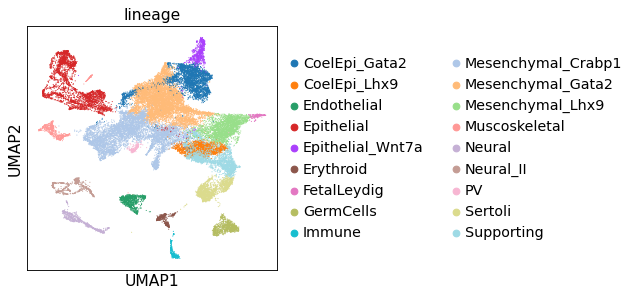

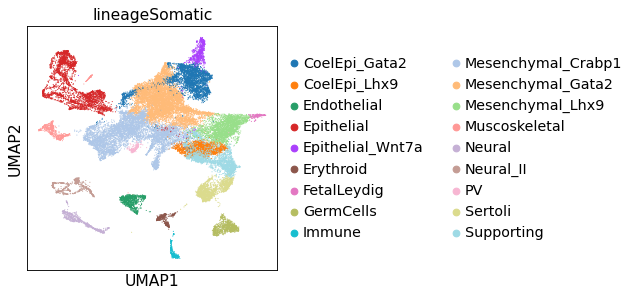

In [32]:
sc.pl.umap(adata, color='lineage')
sc.pl.umap(adata, color='lineageSomatic')

In [33]:
adata.write('/nfs/cellgeni/tickets/tic-613/mouse_main_male.h5ad')